In [1]:
import seaborn as sns
import numpy as np
import pandas as pd
from scipy.stats import chi2
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import warnings
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
import shap
from pre_processing import *

warnings.filterwarnings("ignore")

data = pd.read_csv("data/BatteryFeatures.csv")
results = pd.read_csv("data/results/cort_result_condition.csv")

/home/edu/miniconda3/envs/test/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
cleaned_data = remove_outliers_chi_squared(data)

cycle_life = cleaned_data["cycle_life"]
cleaned_data = cleaned_data.drop(columns=['cycle_life'])

normalized_data = normalize_data(cleaned_data)

discretized_data = discretize_data_with_lower_bounds(normalized_data,bins = 20)

binarized_data = binarize_columns(discretized_data)

In [3]:
results.head()

,Conditions
0,"[""minIR_30 = '1'"", ""deltaQ_min_70 = '0'"", ""IRD..."
1,"[""minIR_30 = '1'"", ""IRDiff2And100_55 = '0'"", ""..."
2,"[""minIR_30 = '1'"", ""tempIntT_45 = '0'"", ""IRDif..."
3,"[""minIR_30 = '1'"", ""IRDiff2And100_55 = '0'"", ""..."
4,"[""minIR_30 = '1'"", ""tempIntT_35 = '0'"", ""IRDif..."


In [4]:
def parse_subgroup(subgroup_str):
    subgroup_str = subgroup_str.strip('[]')
    conditions = subgroup_str.split(', ')
    parsed_conditions = []
    for condition in conditions:
        key, value = condition.split(' = ')
        key = key.strip('"\'')
        value = int(value.strip('"\''))
        parsed_conditions.append((key, value))
    return parsed_conditions

Z = pd.DataFrame(index=binarized_data.index)

for idx, row in results.iterrows():
    subgroup_str = row['Conditions']
    conditions = parse_subgroup(subgroup_str)
    mask = np.ones(len(binarized_data), dtype=bool)
    for key, value in conditions:
        mask &= (binarized_data[key] == value)
    Z[f'Subgroup_{idx + 1}'] = mask.astype(int)

print(Z)

     Subgroup_1  Subgroup_2  Subgroup_3  Subgroup_4  Subgroup_5  Subgroup_6  \
0             0           0           0           0           0           0   
1             0           0           0           0           0           0   
2             0           0           0           0           0           0   
3             0           0           0           0           0           0   
4             0           0           0           0           0           0   
..          ...         ...         ...         ...         ...         ...   
104           0           0           0           0           0           0   
105           0           0           0           0           0           0   
106           0           0           0           0           0           0   
107           0           0           0           0           0           0   
108           0           0           0           0           0           0   

     Subgroup_7  Subgroup_8  Subgroup_9  Subgroup_1

In [5]:
cut_importance = 4.4858398383517235
Y = cycle_life

In [6]:
# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(Z, Y, test_size=0.2, random_state=42)

# Initialize the XGBoost model
model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Train the model
model.fit(X_train, Y_train)

# Predict using the model
Y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(Y_test, Y_pred)
r2 = r2_score(Y_test, Y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

# Display the feature importances
print("Feature Importances:", model.feature_importances_)

Mean Squared Error: 62457.58310494784
R^2 Score: -0.18117213100724783
Feature Importances: [2.73416881e-02 0.00000000e+00 8.16191663e-04 0.00000000e+00
 7.15269998e-05 0.00000000e+00 1.48099498e-05 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 8.25454481e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.52409939e-07 0.00000000e+00 0.00000000e+00 9.92251103e-07
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 8.21031733e-07
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.37019553e-04 0.00000000e+00 1.31321838e-04 0.00000000e+00
 0.00000000e+00 2.46792062e-08 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.27861665e-06 0.00000000e+00 2.07793778e-06
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.0000000

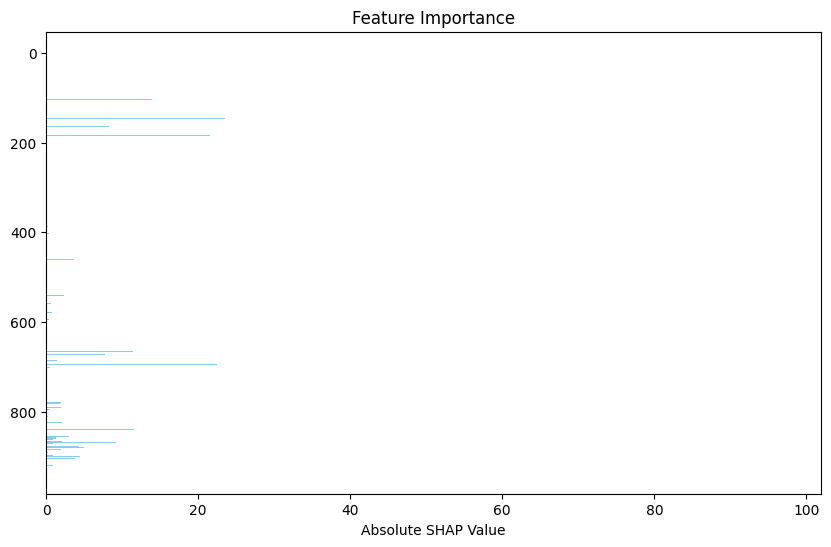

Feature Importance:
     Feature  Importance
819      819   97.077426
0          0   52.417554
208      208   52.052973
935      935   24.213251
146      146   23.582457
..       ...         ...
339      339    0.000000
340      340    0.000000
341      341    0.000000
342      342    0.000000
936      936    0.000000

[937 rows x 2 columns]


In [7]:
# Calculate Shapley values using the shap library
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)

# Compute the mean absolute SHAP values for each feature
mean_abs_shap_values = np.abs(shap_values.values).mean(axis=0)
importance_df = pd.DataFrame({
    "Feature": [i for i in range(X_train.shape[1])],
    "Importance": mean_abs_shap_values
}).sort_values(by="Importance", ascending=False)

# Plot the mean absolute SHAP values
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Absolute SHAP Value')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Highest importance at the top
plt.show()

print("Feature Importance:")
print(importance_df)

In [8]:
important_features = importance_df[importance_df['Importance'] > cut_importance]
important_features

,Feature,Importance
819,819,97.077426
0,0,52.417554
208,208,52.052973
935,935,24.213251
146,146,23.582457
695,695,22.510603
184,184,21.544113
723,723,20.654501
859,859,19.932920
852,852,16.798383


In [9]:
(important_features.mean())[1]

18.309423231528406

In [10]:
important_features.shape

(28, 2)